# Final Group Project. Anime Shows' Platform Recommendations

## 0. Import libraries

In [3]:
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen

import pandas as pd
import numpy as np
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from tqdm import tqdm
import itertools
from collections import defaultdict
#import optuna
#from auto_surprise.engine import Engine
#from bayes_opt import BayesianOptimization


import recmetrics

import random
import os

from IPython.display import clear_output

from surprise import Reader, Dataset, SVD, SVDpp, NMF, accuracy, Prediction, AlgoBase, SlopeOne, KNNBasic, KNNWithZScore, KNNBaseline, KNNWithMeans
from surprise.model_selection import train_test_split, cross_validate, KFold, GridSearchCV

my_seed = 1234
random.seed(my_seed)
np.random.seed(my_seed)

## 1. Importing the dataset

In [4]:
ratings_df = pd.read_csv('anime_ratings.csv')
ratings_df.head()

,user_id,anime_id,rating
0,34992,903,9
1,11536,11697,8
2,7367,509,8
3,73436,4835,10
4,73308,7088,8


## 2. Data exploration

In [5]:
print(f"There are {ratings_df['user_id'].nunique()} unique users")
print(f"There are {ratings_df['anime_id'].nunique()} unique anime shows")
print(f"There are {ratings_df.shape[0]} ratings")

There are 2892 unique users
There are 4326 unique anime shows
There are 35000 ratings


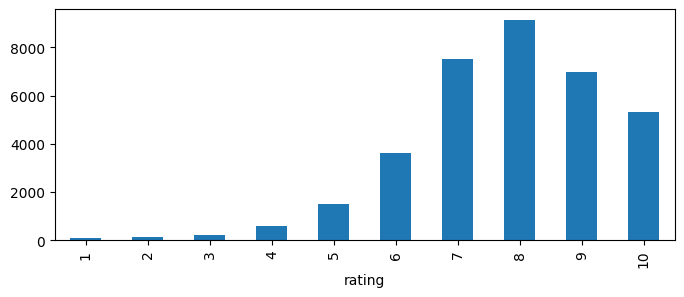

In [6]:
plt.subplots(figsize=(8,3))
ratings_df.groupby('rating').size().plot.bar();

In [7]:
mean = ratings_df['rating'].mean()
std = ratings_df['rating'].std()
print(f'The ratings mean is {round(mean, 2)} and std is {round(std, 4)}')

The ratings mean is 7.82 and std is 1.5562


In [8]:
predictions_mean = [Prediction(uid, iid, r_ui, mean, {}) for uid, iid, r_ui in
                    ratings_df[['user_id', 'anime_id', 'rating']].itertuples(index=False, name=None)]
accuracy.rmse(predictions_mean);

#The RMSE value makes sense since it coincides with the value of the standard deviation.

RMSE: 1.5562


In [9]:
min_rating = ratings_df['rating'].min()
max_rating = ratings_df['rating'].max()

reader = Reader(rating_scale=(min_rating, max_rating)) #specify the scale, that is, the minimum and maximum values
anime_data = Dataset.load_from_df(ratings_df[['user_id', 'anime_id', 'rating']], reader)

In [10]:
trainset, testset = train_test_split(anime_data, test_size=.20, random_state=my_seed) #set a seed because models need to be replicable for auditing purposes

## 3. Defining the recommenders

### Non-personalized recommenders

Define the non-personalized recommenders that will be used as a baseline comparison.

* Random Recommender:

In [11]:
class MyRandomAlgorithm(AlgoBase): #inherits from algorithm base of surprise

    def __init__(self):
        AlgoBase.__init__(self)

    def estimate(self, u, i):
        # Note u and i are not used, this RS does not personalize based on neither the user nor the item
        return np.random.normal(loc=self.train_mean, scale=self.train_std)

    def fit(self, trainset): #fit expects a trainset, never a test set!!!
        AlgoBase.fit(self, trainset)

        ratings = [r for (_, _, r) in self.trainset.all_ratings()]
        self.train_mean = np.mean(ratings)
        self.train_std = np.std(ratings)

        return self

random_RS = MyRandomAlgorithm() #Initialize the random RS

* Popular Recommender

In [12]:
class MyPopularAlgorithm(AlgoBase):

    def __init__(self):
        AlgoBase.__init__(self)

    def estimate(self, u, i):
        # Note u is not used, this RS does not personalize based on the user
        if i in self.mean_rating_per_item_df.index: #if the product was in the train data, use the popularity in the train data;
          return self.mean_rating_per_item_df.loc[i]['rating']
        else:
          return self.trainset.global_mean #otherwise cannot compute the popularity but compute the mean of all items

    def fit(self, trainset):
        AlgoBase.fit(self, trainset)

        #convert bck to a pandas df to later do gorupby and aggregation
        ratings_df = pd.DataFrame([[i, r] for (_, i, r) in self.trainset.all_ratings()],
                                  columns=['item', 'rating'])

        self.mean_rating_per_item_df = (ratings_df
          .groupby('item')
          .agg({'rating': 'mean'}) #extra is the count
        )

        return self

popular_RS = MyPopularAlgorithm()

### Collaborative-filtering recommenders

#### User-based

In [15]:
# MODEL 1: leaving default hyperparameters

model_user_1 = KNNBaseline()
model_user_1.fit(trainset)

# Evaluate performance on test set
predictions_user_1 = model_user_1.test(testset)
rmse = accuracy.rmse(predictions_user_1)
mae = accuracy.mae(predictions_user_1)

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.4414
MAE:  1.1137


#### Item-based

In [16]:
# Model 1: leaving default hyperparameters

model_item_1 = KNNBaseline(
    sim_options={
        'user_based': False
    }
)
model_item_1.fit(trainset)

# Evaluate performance on test set
predictions_item_1 = model_item_1.test(testset)
rmse = accuracy.rmse(predictions_item_1)
mae = accuracy.mae(predictions_item_1)

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.4109
MAE:  1.0707


#### Hyperparameter tuning for memory-based CF recommenders

Before analyzing performance differences due to various hyperparameter configurations in the KNNBasic model, here’s a brief explanation of the parameters:

- k: The maximum number of neighbors considered during aggregation.
- min_k: The minimum number of neighbors required for aggregation.
- sim_options: A set of parameters that includes:
  - name: The type of similarity used.
  - user_based: Set to True, as we're using a user-based algorithm.
  - min_support: The minimum number of common items required to avoid a similarity of 0.


References:

https://surprise.readthedocs.io/en/latest/knn_inspired.html

https://surprise.readthedocs.io/en/latest/prediction_algorithms.html#similarity-measures-configuration

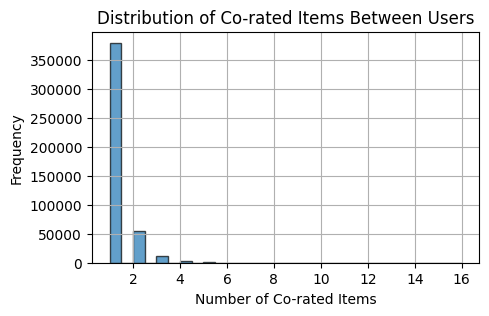

In [18]:
# Check distribution of number of items in common to know what options for min_support would make sense

user_item_mapping = defaultdict(set)
for _, row in ratings_df.iterrows():
    user_item_mapping[row['user_id']].add(row['anime_id'])

# Step 2: Compute pairwise overlap
overlap_counts = []
user_ids = list(user_item_mapping.keys())

# Iterate over all pairs of users
for user1, user2 in itertools.combinations(user_ids, 2):
    # Calculate the number of shared items
    shared_items = user_item_mapping[user1].intersection(user_item_mapping[user2])
    if len(shared_items) > 0:  # Only include pairs with at least 1 shared item
        overlap_counts.append(len(shared_items))

# Step 3: Visualize the distribution
plt.figure(figsize=(5, 3))
plt.hist(overlap_counts, bins=30, edgecolor='k', alpha=0.7)
plt.title("Distribution of Co-rated Items Between Users")
plt.xlabel("Number of Co-rated Items")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [19]:
print(f"Number of User Pairs: {len(overlap_counts)}")
print(f"Average Numer of items in common: {sum(overlap_counts) / len(overlap_counts):.2f}")
print(f"Maximum number of items in common: {max(overlap_counts)}")
max_items_count = overlap_counts.count(max(overlap_counts))
print(f"There are {max_items_count} users with {max(overlap_counts)} items in common")

Number of User Pairs: 450253
Average Numer of items in common: 1.21
Maximum number of items in common: 16
There are 2 users with 16 items in common


We can see most user pairs have 1 item in common. The maximum number of items in common is 16 and only 2 users (one pair) have this high number of items in common. Therefore, for min_support, the maximum value that will be tested is 17 (at this point, all users will get as predictions the global mean of ratings since none will have any neighbors; it makes no sense to waste time and computations on trying more min_support values beyond this since they will all yield the same results).


For hyperparameter tuning, we will use Optuna which implements various techniques for optimization. In this case we defined Tree-structured Parzen Estimator (TPE) for this task. This approach is preferred over Grid Search Cross-Validation because it selectively explores promising hyperparameter combinations based on past trials instead of exhaustively trying out all options, and it allows for continuous search spaces whereas Grid Search CV only searches over pre-defined discrete values. This makes it more likely to find the optimal hyperparameters for the model.

In [ ]:
# Model 2: Memory-based with hyperparameter tuning

# Define objective function with the model to be fit (KNNBaseline) and the hyperparameters to be optimized
def objective(trial):
    k = trial.suggest_int('k', 5, 150, step=5)
    sim_name = trial.suggest_categorical('sim_name', ['cosine', 'msd', 'pearson', 'pearson_baseline'])
    min_support = trial.suggest_int('min_support', 1, 16)
    user_based = trial.suggest_categorical('user_based', [True, False])

    sim_options = {
        'name': sim_name,
        'min_support': min_support,
        'user_based': user_based
    }

    algo = KNNBaseline(k=k, sim_options=sim_options, verbose = False)
    performance = cross_validate(algo, anime_data, measures=['RMSE'], cv=KFold(n_splits=4, random_state=my_seed), verbose=False)
    return np.mean(performance['test_rmse'])

study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=my_seed))
study.optimize(objective, n_trials=100)


# Retrieve the best parameters and RMSE
best_params = study.best_params
best_rmse = study.best_value

# Print results
print("Best parameters:")
for param, value in best_params.items():
    print(f"  {param}: {value}")
print(f"\nBest RMSE from Optimization: {best_rmse:.4f}")


# Retrieve hyperparameters
final_k = best_params['k']
final_name = best_params['sim_name']
final_min_support = best_params['min_support']
final_user_based = best_params['user_based']


# Train the final model
memory_based_final = KNNBaseline(
    k=final_k,
    sim_options={
        'name': final_name,
        'min_support': final_min_support,
        'user_based': final_user_based
    }
)

# Fit the model on the entire dataset
memory_based_final.fit(trainset)

# Evaluate performance on test set
predictions_memory_based = memory_based_final.test(testset)
rmse = accuracy.rmse(predictions_memory_based)
mae = accuracy.mae(predictions_memory_based)

print(f"Memory-based CF Recommender Accuracy: RMSE = {rmse:.4f}, MAE = {mae:.4f}")

[I 2025-03-27 21:24:52,364] A new study created in memory with name: no-name-860b81ee-01fd-41c6-9a28-8e374673c862
[I 2025-03-27 21:24:57,191] Trial 0 finished with value: 1.3386005809188681 and parameters: {'k': 30, 'sim_name': 'pearson', 'min_support': 5, 'user_based': False}. Best is trial 0 with value: 1.3386005809188681.
[I 2025-03-27 21:25:00,989] Trial 1 finished with value: 1.3283350474314255 and parameters: {'k': 145, 'sim_name': 'cosine', 'min_support': 12, 'user_based': False}. Best is trial 1 with value: 1.3283350474314255.
[I 2025-03-27 21:25:05,592] Trial 2 finished with value: 1.32835757477095 and parameters: {'k': 80, 'sim_name': 'pearson', 'min_support': 10, 'user_based': False}. Best is trial 1 with value: 1.3283350474314255.
[I 2025-03-27 21:25:08,315] Trial 3 finished with value: 1.3292290536935352 and parameters: {'k': 140, 'sim_name': 'pearson', 'min_support': 10, 'user_based': True}. Best is trial 1 with value: 1.3283350474314255.
[I 2025-03-27 21:25:13,183] Trial

Best parameters:
  k: 145
  sim_name: cosine
  min_support: 12
  user_based: False

Best RMSE from Optimization: 1.3283
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.3119
MAE:  1.0255
Model-based CF Recommender Accuracy: RMSE = 1.3119, MAE = 1.0255


In [58]:
#BEST CF memory-based model

memory_based_final = KNNBaseline(
    k=145,
    sim_options={
        'name': "cosine",
        'min_support': 12,
        'user_based': False
    }
)

Something to take into account here is that the optimal value for min_support is relatively high (12), and as we know from before very few pairs of users have this many items in common. This means that many predictions will be based on the global mean of ratings instead of actually computing predictions using neighbors of the items (since we have user_based=False) since fefw pairs will reach the necessary min_support to be considered potential neighbors. Still, this yields a high RMSE because of the distribution of ratings: the distribution is highly skewed, most ratings are between 7-10, so predicting the mean will give a relatively low error for most cases, resulting in a low RMSE.

#### Model-based

In [22]:
# Model 1: leaving default hyperparameters

model_svd_1 = SVD(random_state=my_seed)
model_svd_1.fit(trainset)

# Evaluate performance on test set
predictions_svd_1 = model_svd_1.test(testset)
rmse = accuracy.rmse(predictions_svd_1)
mae = accuracy.mae(predictions_svd_1)

RMSE: 1.3033
MAE:  1.0150


In [23]:
# Model 2: with hyperparameter tunning

def objective(trial):
    n_factors = trial.suggest_int('n_factors', 1, 150)
    n_epochs = trial.suggest_int('n_epochs', 1, 100)
    lr_all = trial.suggest_float('lr_all', 0, 0.2)
    reg_all = trial.suggest_float('reg_all', 0, 0.2)
    biased = trial.suggest_categorical('biased', [True, False])

    # Create the SVD algorithm with the suggested hyperparameters
    algo = SVD(
        n_factors=n_factors,
        n_epochs=n_epochs,
        lr_all=lr_all,
        reg_all=reg_all,
        biased=biased,
        random_state=my_seed
    )

    # Perform cross-validation
    performance = cross_validate(
        algo,
        anime_data,
        measures=['RMSE'],
        cv=KFold(n_splits=4, random_state=my_seed),
        verbose=False
    )

    # Return the mean RMSE as the optimization target
    return np.mean(performance['test_rmse'])

# Create and run the Optuna study
study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=my_seed))
study.optimize(objective, n_trials=100)

# Retrieve the best parameters and RMSE
best_params = study.best_params
best_rmse = study.best_value

# Print results
print("Best parameters")
for param, value in best_params.items():
    print(f"  {param}: {value}")
print(f"\nBest RMSE from Optimization: {best_rmse:.4f}")

# Retrieve hyperparameters from the best parameters
final_n_factors = best_params['n_factors']
final_n_epochs = best_params['n_epochs']
final_lr_all = best_params['lr_all']
final_reg_all = best_params['reg_all']
final_biased = best_params['biased']

# Train the final SVD model with optimized hyperparameters
final_model_svd = SVD(
    n_factors=final_n_factors,
    n_epochs=final_n_epochs,
    lr_all=final_lr_all,
    reg_all=final_reg_all,
    biased=final_biased,
    random_state=my_seed  # Ensure reproducibility
)

# Fit the model on the entire training set
final_model_svd.fit(trainset)

# Evaluate performance on the test set
predictions_svd = final_model_svd.test(testset)
rmse = accuracy.rmse(predictions_svd)
mae = accuracy.mae(predictions_svd)

print(f"SVD Recommender Accuracy: RMSE = {rmse:.4f}, MAE = {mae:.4f}")


[I 2025-03-27 21:31:55,056] A new study created in memory with name: no-name-3a0eadfe-b963-4c7b-8052-191ec3da3573
[I 2025-03-27 21:32:01,010] Trial 0 finished with value: 1.3503133991928284 and parameters: {'n_factors': 29, 'n_epochs': 63, 'lr_all': 0.0875455478014229, 'reg_all': 0.15707171674275386, 'biased': True}. Best is trial 0 with value: 1.3503133991928284.
[I 2025-03-27 21:32:05,731] Trial 1 finished with value: 2.587807341010448 and parameters: {'n_factors': 42, 'n_epochs': 81, 'lr_all': 0.19162787073674103, 'reg_all': 0.17518652694841896, 'biased': False}. Best is trial 0 with value: 1.3503133991928284.
[I 2025-03-27 21:32:10,526] Trial 2 finished with value: 1.3395241672969744 and parameters: {'n_factors': 103, 'n_epochs': 72, 'lr_all': 0.07405015095807899, 'reg_all': 0.112239237213125, 'biased': True}. Best is trial 2 with value: 1.3395241672969744.
[I 2025-03-27 21:32:17,313] Trial 3 finished with value: 1.6538663870088557 and parameters: {'n_factors': 116, 'n_epochs': 89,

Best parameters
  n_factors: 22
  n_epochs: 13
  lr_all: 0.013541839917569198
  reg_all: 0.07175640430597308
  biased: True

Best RMSE from Optimization: 1.2984
RMSE: 1.2867
MAE:  0.9971
SVD Recommender Accuracy: RMSE = 1.2867, MAE = 0.9971


In [59]:
#BEST CF model-based recommender

final_model_svd = SVD(
    n_factors=22,
    n_epochs=13,
    lr_all=0.013541839917569198,
    reg_all=0.07175640430597308,
    biased=True,
    random_state=my_seed  # Ensure reproducibility
)

#### Using Auto Surprise Library

In [ ]:
# Intitialize auto surprise engine
engine = Engine(verbose=False)

# Start the trainer
best_algo, best_params, best_score, tasks = engine.train(
    data=anime_data,
    target_metric='test_rmse',
    cpu_time_limit=60 * 60, # Run for 1 hour
    max_evals=200
)

# Print the best RMSE
print(f"Best RMSE from AutoSurprise: {best_score:.4f}")

# Print the best parameters
print("Best Parameters:")
for param, value in best_params.items():
    print(f"  {param}: {value}")

print(best_algo)

Best RMSE from AutoSurprise: 1.2844
Best Parameters:
  bsl_options: {'learning_rate': 0.014802605544842624, 'method': 'sgd', 'reg': 0.021991685380942688}
  k: 149
  min_k: 22
  sim_options: {'name': 'cosine', 'user_based': False, 'min_support': 1}


In [26]:
# Fit best model from results above
bsl_options = {'learning_rate': 0.014802605544842624, 'method': 'sgd', 'reg': 0.021991685380942688}
k = 149
min_k = 22
sim_options = {'name': 'cosine', 'user_based': False, 'min_support': 1}

# Initialize the best algorithm with the retrieved parameters
cf_best = KNNBaseline(k=k, min_k=min_k, sim_options=sim_options, bsl_options=bsl_options, verbose=False)

# Fit the model to the trainset
cf_best.fit(trainset)

# Evaluate the model on the testset
predictions_best_cf = cf_best.test(testset)
rmse = accuracy.rmse(predictions_best_cf)
mae = accuracy.mae(predictions_best_cf)

print(f"AutoSurprise Best Model Accuracy: RMSE = {rmse:.4f}, MAE = {mae:.4f}")

RMSE: 1.2799
MAE:  0.9854
AutoSurprise Best Model Accuracy: RMSE = 1.2799, MAE = 0.9854


### Content-based recommender

In [13]:
anime_df = pd.read_csv('data/anime.csv')
anime_df.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


The content-based recommender will provide recommendations based on both categorical and numerical variables. Categorical variables include the genre and type of the shows; while the numerical variables include its number of episodes and subscribed members. 

The logic that will be applied to retrieve a list of recommendations for a given user is the following: 
based on the cosine similarities matrix from both types of variables, a list of recommendations (ordered descendently by distance) will be provided for each of a number of interacted shows by the user. Our selected threshold was 10, at most, number of shows for which individual recommendations will be provided. If the number of interactions for the user is lower than 10, all of those anime shows will have a list of recommendations. However, if the number of interactions is greater than 10, we will randomly pick 10 of them. 
Once we have an individual list of recommendations for each show (at most 10) that the user has interacted with, we will compute the average of their distance scores to obtain a new and final list which considers equally all interactions chosen. 

Note: the computation of the final similarity matrix in the ContentRS class is performed in a weighted manner, we assume that the categorical variables have a slightly higher weight since in films/shows streaming platforms, such as Netflix, the filters most likely include these. 

In [14]:
# Content-Based Recommender Class using the mapping
from surprise.prediction_algorithms.predictions import Prediction  # Using Prediction from Surprise

class ContentRS_Multi_Item:
    def __init__(self, anime_df, cosine_sim_cat, cosine_sim_num, weight_num, weight_cat, id_to_index):
        self.anime_df = anime_df
        self.cosine_sim_cat = cosine_sim_cat
        self.cosine_sim_num = cosine_sim_num
        self.id_to_index = id_to_index  # Save the mapping
        # Combine similarities using weights
        self.similarity_matrix = weight_num * self.cosine_sim_num + weight_cat * self.cosine_sim_cat

    def get_recommendations(self, anime_ids):
        """
        Given a list of anime_ids, compute the average similarity score for each anime,
        and return recommendations sorted by descending similarity, excluding the input anime.
        """
        # Use the mapping to get correct indices
        idx_list = [self.id_to_index[anime_id] for anime_id in anime_ids if anime_id in self.id_to_index]

        # Initialize an array to accumulate similarity scores
        accumulated_scores = np.zeros(self.similarity_matrix.shape[0])

        # Sum similarity scores for the selected anime indices
        for idx in idx_list:
            accumulated_scores += self.similarity_matrix[idx]

        # Calculate average similarity scores
        avg_scores = accumulated_scores / len(idx_list)

        # Create a list of (index, similarity_score) and sort descending
        sim_scores = list(enumerate(avg_scores))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        # Exclude the input anime themselves
        sim_scores = [pair for pair in sim_scores if pair[0] not in idx_list]

        # Retrieve recommended indices and scores
        recommended_indices = [i for i, score in sim_scores]
        scores = [score for i, score in sim_scores]

        # Fill NaN scores with 0 using numpy.nan_to_num
        scores = np.nan_to_num(scores, nan=0.0)

        # Get recommendations from the DataFrame and add the score column
        rec_df = self.anime_df.iloc[recommended_indices].copy()
        rec_df['score'] = scores
        return rec_df

    def fit(self):
        pass


However, the above logic, while it can get more averaged predictions by considering several user interactions, it does not mimic the real logic followed by streaming platforms. Usually, only on the interacted items is chosen and the most similar items to it, in terms of metadata, are recommended. Therefore, we will create another class which resembles this logic.

In [28]:
# Content-Based Recommender Class using the mapping
class ContentRS_Single_Item:
    def __init__(self, anime_df, cosine_sim_cat, cosine_sim_num, weight_num, weight_cat, id_to_index):
        self.anime_df = anime_df
        self.cosine_sim_cat = cosine_sim_cat
        self.cosine_sim_num = cosine_sim_num
        self.id_to_index = id_to_index  # Mapping from anime_id to DataFrame index
        # Combine similarities using weights
        self.similarity_matrix = weight_num * self.cosine_sim_num + weight_cat * self.cosine_sim_cat

    def get_recommendations(self, selected_anime):
        """
        Given a single selected anime id, print its id and return recommendations
        based solely on that anime's similarity scores.
        """
        if selected_anime not in self.id_to_index:
            print("Selected anime id is not in the mapping.")
            return pd.DataFrame()
        
        idx = self.id_to_index[selected_anime]
        
        # Get the similarity scores for the selected anime
        similarity_scores = self.similarity_matrix[idx]
        
        # Create a list of (index, similarity_score) pairs sorted in descending order
        sim_scores = list(enumerate(similarity_scores))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        
        # Exclude the selected anime itself
        sim_scores = [pair for pair in sim_scores if pair[0] != idx]
        
        # Retrieve the recommended indices and their scores
        recommended_indices = [i for i, score in sim_scores]
        scores = [score for i, score in sim_scores]
        
        # Replace any NaN scores with 0
        scores = np.nan_to_num(scores, nan=0.0)
        
        # Get recommendations from the DataFrame and add a 'score' column
        rec_df = self.anime_df.iloc[recommended_indices].copy()
        rec_df['score'] = scores
        return rec_df

    def fit(self):
        # Additional training logic (if needed) goes here.
        pass


## 5. Comparison of CF vs. non-personalized

### A) Performance/Accuracy

In [ ]:
random_RS.fit(trainset);
predictions_random = random_RS.test(testset)
accuracy.rmse(predictions_random, verbose=True);
accuracy.mae(predictions_random, verbose=True);


RMSE: 2.1243
MAE:  1.6880


In [ ]:
popular_RS.fit(trainset);
predictions_popular = popular_RS.test(testset)
accuracy.rmse(predictions_popular, verbose=True);
accuracy.mae(predictions_popular, verbose=True);

RMSE: 1.4388
MAE:  1.1164


In [ ]:
item_based_RS.fit(trainset);
predictions_itemb = item_based_RS.test(testset)
accuracy.rmse(predictions_itemb, verbose=True);
accuracy.mae(predictions_itemb, verbose=True);

RMSE: 1.2248
MAE:  0.9260


In [ ]:
user_based_RS.fit(trainset);
predictions_userb = user_based_RS.test(testset)
accuracy.rmse(predictions_userb, verbose=True);
accuracy.mae(predictions_userb, verbose=True);

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.4359
MAE:  1.1083


In [ ]:
model_based_RS.fit(trainset);
predictions_modelb = model_based_RS.test(testset)
accuracy.rmse(predictions_modelb, verbose=True);
accuracy.mae(predictions_modelb, verbose=True);

RMSE: 1.1970
MAE:  0.9045


Among the three collaborative filtering methods evaluated, the model-based recommender achieved the highest accuracy, recording the lowest RMSE and MAE values. The item-based recommender performed nearly as well, though slightly behind the model-based approach. In contrast, the user-based recommender produced accuracy scores similar to the popular recommender, which suggests it may require additional fine-tuning to generate more personalized recommendations. As expected, the random recommender performed the worst due to its reliance on random selection rather than data-driven insights.

In [ ]:
columns=['user', 'item', 'true_rating', 'predicted_rating', 'details']
predictions_random_df = pd.DataFrame(predictions_random, columns=columns)
predictions_popular_df = pd.DataFrame(predictions_popular, columns=columns)
predictions_cf_item = pd.DataFrame(predictions_itemb, columns=columns)
predictions_cf_user = pd.DataFrame(predictions_userb, columns=columns)
predictions_cf_model = pd.DataFrame(predictions_modelb, columns=columns)

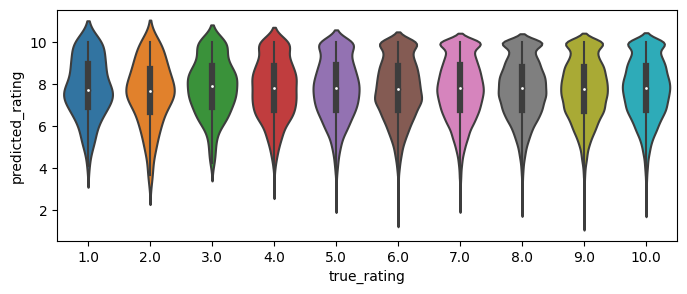

In [ ]:
#Violin plot for random recommender
plt.subplots(figsize=(8,3));
sns.violinplot(data=predictions_random_df, x="true_rating", y="predicted_rating");

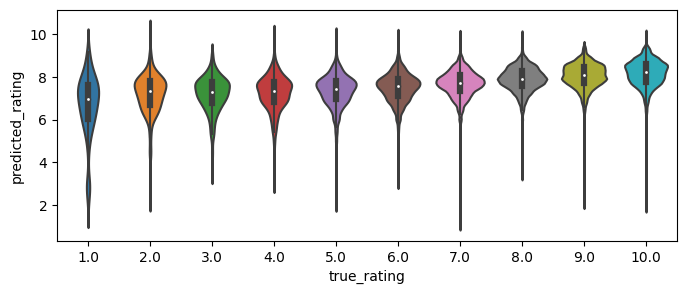

In [ ]:
#Violin plot for popular recommender
plt.subplots(figsize=(8,3));
sns.violinplot(data=predictions_popular_df, x="true_rating", y="predicted_rating");

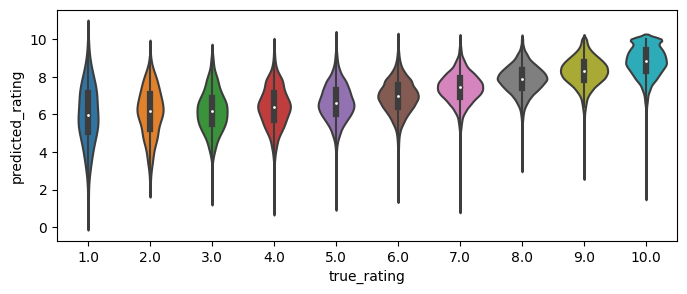

In [ ]:
#Violin plot for cf item based recommender
plt.subplots(figsize=(8,3));
sns.violinplot(data=predictions_cf_item, x="true_rating", y="predicted_rating");

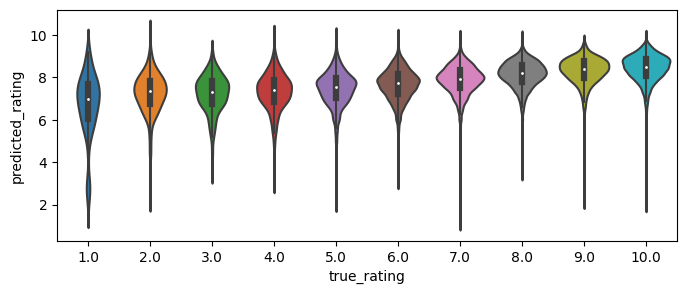

In [ ]:
#Violin plot for cf user based recommender
plt.subplots(figsize=(8,3));
sns.violinplot(data=predictions_cf_user, x="true_rating", y="predicted_rating");

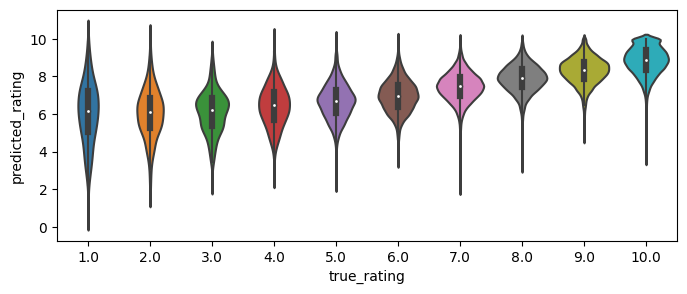

In [ ]:
#Violin plot for cf model based recommender
plt.subplots(figsize=(8,3));
sns.violinplot(data=predictions_cf_model, x="true_rating", y="predicted_rating");

The violin plots clearly illustrate a significant difference in performance. With the random recommender, the prediction distributions are broadly spread, showing little alignment with the actual rating values. In contrast, as we move to collaborative-filtering approaches, the distributions become more concentrated and closely tailored to the true ratings. Although the popular recommender performs similarly to these methods, there remains potential for further enhancement.

### B) Additional metrics besides accuracy

For the content-based recommendations, we have to filter out the animes from the original anime_df that don't appear in the sampled ratings dataframe, otherwise when computing the non-accuracy metrics, such as, coverage we will obtain unusual values (more than 100% of the catalog) since we are considering items that are not in the catalog of the filtered dataset. Another important consideration is that the index of these filtered anime_ids have to be changed because some of them may be outside the new dimension. 

In [35]:
# Filter and reset index on anime_df
anime_ids_filtered = ratings_df['anime_id'].unique()
anime_df_filtered = anime_df[anime_df['anime_id'].isin(anime_ids_filtered)].copy()
anime_df_filtered.reset_index(drop=True, inplace=True)

# Create a mapping from anime_id to new index (0 to n-1)
id_to_index = pd.Series(anime_df_filtered.index, index=anime_df_filtered['anime_id']).to_dict()

# Now compute the similarity matrices using anime_df_filtered (after reset)
# Categorical Similarity Calculation
from sklearn.feature_extraction.text import CountVectorizer
categorical_cols = ['genre', 'type']
items_cat_df = anime_df_filtered[categorical_cols].copy()
items_cat_df = items_cat_df.apply(lambda x: x.str.lower())
items_cat_df = items_cat_df.apply(lambda x: x.str.replace(' ', '').str.replace(',', ''))
items_cat_df = items_cat_df.fillna('').astype(str)
items_cat_df['soup'] = items_cat_df[categorical_cols].agg(' '.join, axis=1)
vectorizer = CountVectorizer()
count_matrix = vectorizer.fit_transform(items_cat_df['soup'])
from sklearn.metrics.pairwise import cosine_similarity
cosine_sim_cat = cosine_similarity(count_matrix)

# Numerical Similarity Calculation
from sklearn.preprocessing import StandardScaler
numerical_cols = ['episodes', 'members']
anime_df_filtered[numerical_cols] = anime_df_filtered[numerical_cols].apply(pd.to_numeric, errors='coerce')
numerical_data = anime_df_filtered[numerical_cols]
numerical_data_filled = numerical_data.fillna(numerical_data.mean())
scaler = StandardScaler()
numerical_data_scaled = scaler.fit_transform(numerical_data_filled)
cosine_sim_num = cosine_similarity(numerical_data_scaled)


First, we will instantiate the content recommender that considers multiple items (up to 10) for the computation of the final recommendations list based on the average similarities scores list. 

In [17]:
# Initialization code
weight_num = 0.4
weight_cat = 0.6
content_rs_multi = ContentRS_Multi_Item(anime_df_filtered, cosine_sim_cat, cosine_sim_num, weight_num, weight_cat, id_to_index)

# Generate predictions (the rest of your code remains the same)
user_watched_items = ratings_df.groupby('user_id')['anime_id'].apply(list)
predictions_content_multi = []
n_items_per_user = 10
default_r_ui = ratings_df['rating'].mean()  # Using the mean rating as default
my_seed = 42

for user_id, watched_anime_ids in user_watched_items.items():
    if len(watched_anime_ids) < n_items_per_user:
        selected_anime_ids = watched_anime_ids
    else:
        random.seed(my_seed)
        selected_anime_ids = random.sample(watched_anime_ids, n_items_per_user)

    rec_df = content_rs_multi.get_recommendations(selected_anime_ids)
    for _, row in rec_df.iterrows():
        predictions_content_multi.append(
            Prediction(
                uid=user_id,
                iid=row['anime_id'],
                r_ui=default_r_ui,
                est=row['score'],
                details={'was_impossible': False}
            )
        )

Now, we will define the content recommender based randomly only on one of the items each user has interacted with. 

In [36]:
# Initialization code
weight_num = 0.4
weight_cat = 0.6
content_rs_single = ContentRS_Single_Item(anime_df_filtered, cosine_sim_cat, cosine_sim_num,
                                          weight_num, weight_cat, id_to_index)

# Generate predictions using the single-item approach for each user
user_watched_items = ratings_df.groupby('user_id')['anime_id'].apply(list)
predictions_content_single = []
default_r_ui = ratings_df['rating'].mean()  # Using the mean rating as default
my_seed = 42

for user_id, watched_anime_ids in user_watched_items.items():
    # Randomly choose one anime id from the watched list using the seed
    random.seed(my_seed)
    selected_anime_id = random.choice(watched_anime_ids)
    print("User:", user_id, "selected anime id:", selected_anime_id)
    
    # Pass the selected id as a single-item list to get_recommendations
    rec_df = content_rs_single.get_recommendations(selected_anime_id)
    
    # Convert recommendations into Surprise Prediction objects
    for _, row in rec_df.iterrows():
        predictions_content_single.append(
            Prediction(
                uid=user_id,
                iid=row['anime_id'],
                r_ui=default_r_ui,
                est=row['score'],
                details={'was_impossible': False}
            )
        )


User: 18 selected anime id: 27899
User: 33 selected anime id: 1535
User: 47 selected anime id: 996
User: 61 selected anime id: 9756
User: 80 selected anime id: 19815
User: 126 selected anime id: 777
User: 129 selected anime id: 6637
User: 200 selected anime id: 14345
User: 226 selected anime id: 668
User: 228 selected anime id: 9756
User: 239 selected anime id: 11771
User: 271 selected anime id: 20939
User: 278 selected anime id: 4224
User: 291 selected anime id: 2236
User: 377 selected anime id: 10161
User: 412 selected anime id: 3342
User: 446 selected anime id: 5342
User: 462 selected anime id: 32438
User: 492 selected anime id: 10165
User: 501 selected anime id: 20899
User: 515 selected anime id: 8425
User: 561 selected anime id: 20507
User: 564 selected anime id: 14967
User: 585 selected anime id: 22135
User: 601 selected anime id: 1840
User: 610 selected anime id: 317
User: 642 selected anime id: 10321
User: 653 selected anime id: 523
User: 701 selected anime id: 270
User: 737 se

To address the long tail phenomenon, I will increase the maximum rating from 10 to 20. Given that the average rating is around 8, we anticipate a considerable number of predictions exceeding 10. If we were to cap the ratings at 10, those higher predictions would be excluded, preventing the top scores from being properly distinguished. This limitation would especially affect the coverage metric for the random recommender that should be of 100%.

In [40]:
min_rating = ratings_df['rating'].min()
max_rating = ratings_df['rating'].max() + 10

reader = Reader(rating_scale=(min_rating, max_rating)) #specify the scale, that is, the minimum and maximum values
anime_data_scaled = Dataset.load_from_df(ratings_df[['user_id', 'anime_id', 'rating']], reader)

In [ ]:
trainset_nonacc = anime_data_scaled.build_full_trainset()
testset_nonacc = trainset.build_anti_testset()

random_RS.fit(trainset_nonacc);
popular_RS.fit(trainset_nonacc);
model_item_1.fit(trainset_nonacc);
model_user_1.fit(trainset_nonacc);
model_svd_1.fit(trainset_nonacc);


predictions_random  = random_RS.test(testset_nonacc)
predictions_popular = popular_RS.test(testset_nonacc)
predictions_cf_item = model_item_1.test(testset_nonacc)
predictions_cf_user = model_user_1.test(testset_nonacc)
predictions_cf_model = model_svd_1.test(testset_nonacc)

NameError: name 'model_item_1' is not defined

In [37]:
# https://github.com/NicolasHug/Surprise/blob/master/examples/top_n_recommendations.py
def get_top_n(predictions, n=10, solve_ties=False):
    from collections import defaultdict
    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        if solve_ties:
            user_ratings.sort(key=lambda x: (x[1], x[0]), reverse=True)
        else:
            user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [ ]:
top_n_random  = get_top_n(predictions_random, n=50)
top_n_popular = get_top_n(predictions_popular, n=50, solve_ties=True)  # Remove randomness
top_n_cf_item = get_top_n(predictions_cf_item, n=50)
top_n_cf_user = get_top_n(predictions_cf_user, n=50)
top_n_cf_model = get_top_n(predictions_cf_model, n=50)
top_n_content_multi = get_top_n(predictions_content_multi, n=50)
top_n_content_single = get_top_n(predictions_content_single, n=50)

In [ ]:
top_n_random_only_items  = [[iid for (iid, _) in user_ratings] for user_ratings in top_n_random.values()]
top_n_popular_only_items = [[iid for (iid, _) in user_ratings] for user_ratings in top_n_popular.values()]
top_n_cfitem_only_items      = [[iid for (iid, _) in user_ratings] for user_ratings in top_n_cf_item.values()]
top_n_cfuser_only_items      = [[iid for (iid, _) in user_ratings] for user_ratings in top_n_cf_user.values()]
top_n_cfmodel_only_items     = [[iid for (iid, _) in user_ratings] for user_ratings in top_n_cf_model.values()]
top_n_contentm_only_items    = [[iid for (iid, _) in user_ratings] for user_ratings in top_n_content_multi.values()]
top_n_contents_only_items    = [[iid for (iid, _) in user_ratings] for user_ratings in top_n_content_single.values()]

* Coverage

In [ ]:
catalog = [trainset_nonacc.to_raw_iid(inner_iid) for inner_iid in trainset_nonacc.all_items()]
coverage_random = recmetrics.prediction_coverage(top_n_random_only_items, catalog)
print(f'Random coverage: {coverage_random}')
coverage_popular = recmetrics.prediction_coverage(top_n_popular_only_items, catalog)
print(f'Popular coverage: {coverage_popular}')
coverage_itemcf = recmetrics.prediction_coverage(top_n_cfitem_only_items, catalog)
print(f'CF item-based coverage: {coverage_itemcf}')
coverage_usercf = recmetrics.prediction_coverage(top_n_cfuser_only_items, catalog)
print(f'CF user-based coverage: {coverage_usercf}')
coverage_modelcf = recmetrics.prediction_coverage(top_n_cfmodel_only_items, catalog)
print(f'CF model-based coverage: {coverage_modelcf}')
coverage_content_m = recmetrics.prediction_coverage(top_n_contentm_only_items, catalog)
print(f'Content-based (multi-item) coverage: {coverage_content_m}')
coverage_content_s = recmetrics.prediction_coverage(top_n_contents_only_items, catalog)
print(f'Content-based (single-item) coverage: {coverage_content_s}')

Random coverage: 100.0
Popular coverage: 1.96
CF item-based coverage: 73.12
CF user-based coverage: 64.55
CF model-based coverage: 11.08
Content-based coverage: 163.59


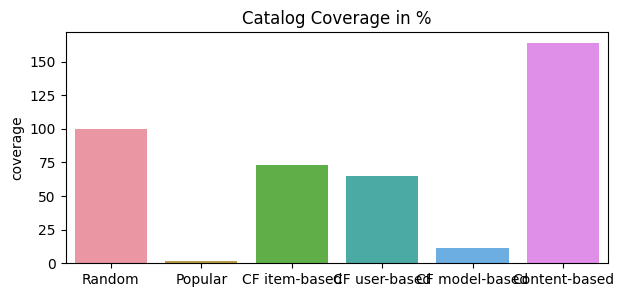

In [ ]:
fig = plt.figure(figsize=(7, 3))
model_names = ['Random', 'Popular', 'CF item', 'CF user', 'CF model', "Content M", "Content S"]
recmetrics.coverage_plot([coverage_random, coverage_popular, coverage_itemcf, coverage_usercf, coverage_modelcf, coverage_content_m ,coverage_content_s], model_names)

In [62]:
#Number of items in ratings_df
num_items = len(ratings_df['anime_id'].unique())
#Number of users in ratings_df
num_users = len(ratings_df['user_id'].unique())
print(f"Number of items in ratings_df: {num_items}")
print(f"Number of users in ratings_df: {num_users}")

Number of items in ratings_df: 4326
Number of users in ratings_df: 2892


From a coverage standpoint, the popular recommender underperforms by covering only the top 50 items. In contrast, the random recommender achieves 100% coverage (after adjusting the scale), as every item has an equal chance of being recommended after adjusting the rating scale. Both the item-based and user-based collaborative filtering systems demonstrate similar performance, covering over 60% of the catalog since users interact with a diverse set of items and vice versa. What stands out is the model-based recommender's lower coverage, which may be due to the lack of fine-tuning, suggesting that further optimization could lead to significant improvements in coverage.

The multi content-based recommended achieves a comparable performance with the random recommender, which suggests that average the distances of the recommendations for a number of items is effective. A similar performance is seen in the single item content based because the distinct items selected for each of the 2892 users and their respective 50 recommendations can easily cover a big proportion of the total number of 4326 items. 

* Personalization

In [ ]:
personalization_random = recmetrics.personalization(top_n_random_only_items)
print(f'Random personalization: {personalization_random}')
personalization_popular = recmetrics.personalization(top_n_popular_only_items)
print(f'Popular personalization: {personalization_popular}')
personalization_cf_item = recmetrics.personalization(top_n_cfitem_only_items)
print(f'CF item-based personalization: {personalization_cf_item}')
personalization_cf_user = recmetrics.personalization(top_n_cfuser_only_items)
print(f'CF user-based personalization: {personalization_cf_user}')
personalization_cf_model = recmetrics.personalization(top_n_cfmodel_only_items)
print(f'CF model-based personalization: {personalization_cf_model}')
personalization_content= recmetrics.personalization(top_n_contentm_only_items)
print(f'Content-based personalization: {personalization_content}')
personalization_content= recmetrics.personalization(top_n_contents_only_items)
print(f'Content-based personalization: {personalization_content}')

Random personalization: 0.9815156670879517
Popular personalization: 0.0010221614989267547
CF item-based personalization: 0.860218718570062
CF user-based personalization: 0.9006871109344945
CF model-based personalization: 0.30312914875180585
Content-based personalization: 0.9599393103900333


In [61]:
user_watched_items = ratings_df.groupby('user_id')['anime_id'].apply(list)
user_watched_items
#Calculate the number of watched items for each user
user_watched_items_count = user_watched_items.apply(len)
#Calculate the average number of watched items
average_watched_items = user_watched_items_count.mean()
print(f"Average number of watched items per user: {average_watched_items:.2f}")

Average number of watched items per user: 12.10


From a personalization perspective, which measures how different recommendation lists are across users, the popular recommender scores the lowest (almost close to zero) since it provides the same list to every user (unless it's modified, for example, using demographic filtering). In contrast, the random recommender achieves the highest personalization because its inherently random nature makes it very unlikely for two users to receive similar recommendations. Both the item-based and user-based collaborative filtering recommenders also perform well in personalization, as they tailor recommendations to each user's distinct preferences. It is, however, surprising that the model-based recommender shows a lower personalization score, suggesting again that it may require further fine-tuning to match the performance of the other collaborative filtering methods.

For the multi content recommender, the aforementioned mixing of predictions allows to return distinct lists because the interacted items between users differ and there is a random factor when choosing 10 of the interacted items, which depicts a desired outcome in this metric. This trend holds also with the single item content recommender since only one random item was chosen per user, and the average number of interactions is around 12 anime shows, which lowers the probability of having the exact same item selected. 


* Diversity

In [ ]:
anime_df = anime_df[['anime_id']].join(anime_df['genre'].str.get_dummies(sep=', ')).set_index('anime_id')

diversity_random = recmetrics.intra_list_similarity(top_n_random_only_items, anime_df)
print(f'Random diversity: {diversity_random}')
diversity_popular = recmetrics.intra_list_similarity(top_n_popular_only_items, anime_df)
print(f'Popular diversity: {diversity_popular}')
diversity_cf_item = recmetrics.intra_list_similarity(top_n_cfitem_only_items, anime_df)
print(f'CF diversity: {diversity_cf_item}')
diversity_cf_user = recmetrics.intra_list_similarity(top_n_cfuser_only_items, anime_df)
print(f'CF diversity: {diversity_cf_user}')
diversity_cf_model = recmetrics.intra_list_similarity(top_n_cfmodel_only_items, anime_df)
print(f'CF diversity: {diversity_cf_model}')
diversity_content_multi = recmetrics.intra_list_similarity(top_n_contentm_only_items, anime_df)
print(f'Content diversity: {diversity_content_multi}')
diversity_content_single = recmetrics.intra_list_similarity(top_n_contents_only_items, anime_df)
print(f'Content diversity: {diversity_content_single}')

,Action,Adventure,Cars,Comedy,Dementia,Demons,Drama,Ecchi,Fantasy,Game,...,Shounen Ai,Slice of Life,Space,Sports,Super Power,Supernatural,Thriller,Vampire,Yaoi,Yuri
anime_id,,,,,,,,,,,,,,,,,,,,,
32281,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
5114,1,1,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
28977,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9253,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
9969,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


From a diversity perspective, the collaborative filtering recommenders show similar scores, outperforming both the random and popular recommenders. Notably, the popular recommender scores the lowest, as its diversity is limited by the range of categories among the top 50 most popular items. Although the random recommender generally has the potential to offer higher diversity, in this specific instance its top predictions sometimes end up being concentrated in a single category, thereby reducing its diversity score.

It’s also important to mention that the diversity metric was computed using the top 50 items. Adjusting the size of this top list (k) could lead to different outcomes. The similarity in scores across the recommenders might indicate that the top 50 sample itself is biased possibly because a majority of the items (e.g., anime shows) belong to the same category.

As of the content-based model, both multi and single item slightly outperform the other recommender. This outcome can seem as unexpected, since we expect that the all lists of recommendations include similar items as the cosine distance was used to return them. However, it is important to consider that for the similarity matrix several metadata columns (numerical and categorical) were considered for the computation, however, in the diversity metric we are only considering the genre metadata. Therefore, we can have two different animes from the same genre but this similarity can be offset by a disimilarity in the number of episodes or members they have. 

* Summary plot

In [36]:
recmetrics.metrics_plot(model_names=model_names,
                        coverage_scores=[coverage_random, coverage_popular, coverage_itemcf, coverage_usercf, coverage_modelcf, coverage_content],
                        personalization_scores=[personalization_random, personalization_popular, personalization_cf_item, personalization_cf_user, personalization_cf_model, personalization_content],
                        intra_list_similarity_scores = [diversity_random, diversity_popular, diversity_cf_item, diversity_cf_user, diversity_cf_model,diversity_content])


The summary plot consolidates the following key observations:

* Random Recommender: It achieves personalization and diversity scores comparable to the CF methods, and it offers full coverage.
* Popular Recommender: It registers zero personalization and less than 2% coverage, matching the others only in terms of diversity.
* CF Item-Based and CF User-Based: Both methods perform similarly, exhibiting high personalization, high coverage, and diversity scores that align with the other systems.
* CF Model-Based Recommender: It shows low personalization and coverage, though its diversity is comparable. This performance is unexpected for a CF model, suggesting that further fine-tuning is necessary.
* Content Recommender: It achieves high coverage and personalization scores (comparable to that of random recommender), while also reaching the highest level in diversity among the six baseline models.

### C) NDCG

In [ ]:
popular_RS.fit(trainset);
predictions_popular = popular_RS.test(testset)
predictions_popular_df = pd.DataFrame(predictions_popular)
predictions_popular_df['est'] = predictions_popular_df['est'].round(2)

random_RS.fit(trainset);
predictions_random = random_RS.test(testset)
predictions_random_df = pd.DataFrame(predictions_random)
predictions_random_df['est'] = predictions_random_df['est'].round(2)

model_item_1.fit(trainset);
predictions_cfitem = model_item_1.test(testset)
predictions_cfitem_df = pd.DataFrame(predictions_cfitem)
predictions_cfitem_df['est'] = predictions_cfitem_df['est'].round(2)


model_user_1.fit(trainset);
predictions_cfuser = model_user_1.test(testset)
predictions_cfuser_df = pd.DataFrame(predictions_cfuser)
predictions_cfuser_df['est'] = predictions_cfuser_df['est'].round(2)


model_svd_1.fit(trainset);
predictions_cfmodel = model_svd_1.test(testset)
predictions_cfmodel_df = pd.DataFrame(predictions_cfmodel)
predictions_cfmodel_df['est'] = predictions_cfmodel_df['est'].round(2)

predictions_contentm_df = pd.DataFrame(predictions_content_multi)
predictions_contentm_df['est'] = predictions_contentm_df['est'].round(2)

predictions_contents_df = pd.DataFrame(predictions_content_single)
predictions_contents_df['est'] = predictions_contentm_df['est'].round(2)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [50]:
def ndcg_multiple_users(relevant_items_all_users, predictions_ranking_all_users, k=5):
    ndcg_list = []
    # Loop all users
    for i in range(len(relevant_items_all_users)):
      # Skip users with only 1 item in the test data, as no NDCG can be computed
      if len(relevant_items_all_users[i]) > 1:
        ndcg = metrics.ndcg_score([relevant_items_all_users[i]],
                                  [predictions_ranking_all_users[i]], k=k)
        ndcg_list.append(ndcg)

    return np.mean(ndcg_list)

In [ ]:
predictions_random_byuser_df = predictions_random_df.groupby('uid')[['iid', 'r_ui', 'est']].agg(lambda x: list(x))
ndcg_multiple_users(predictions_random_byuser_df['r_ui'].tolist(),
                    predictions_random_byuser_df['est'].tolist())

0.8797727158526927

In [ ]:
predictions_popular_byuser_df = predictions_popular_df.groupby('uid')[['iid', 'r_ui', 'est']].agg(lambda x: list(x))
ndcg_multiple_users(predictions_popular_byuser_df['r_ui'].tolist(),
                    predictions_popular_byuser_df['est'].tolist())

0.9381698074611137

In [ ]:
predictions_cfitem_byuser_df = predictions_cfitem_df.groupby('uid')[['iid', 'r_ui', 'est']].agg(lambda x: list(x))
ndcg_multiple_users(predictions_cfitem_byuser_df['r_ui'].tolist(),
                    predictions_cfitem_byuser_df['est'].tolist())

0.9385684664140348

In [ ]:
predictions_cfuser_byuser_df = predictions_cfuser_df.groupby('uid')[['iid', 'r_ui', 'est']].agg(lambda x: list(x))
ndcg_multiple_users(predictions_cfuser_byuser_df['r_ui'].tolist(),
                    predictions_cfuser_byuser_df['est'].tolist())

0.9381323107711809

In [ ]:
predictions_cfmodel_byuser_df = predictions_cfmodel_df.groupby('uid')[['iid', 'r_ui', 'est']].agg(lambda x: list(x))
ndcg_multiple_users(predictions_cfmodel_byuser_df['r_ui'].tolist(),
                    predictions_cfmodel_byuser_df['est'].tolist())

0.9422730098997167

In [55]:
predictions_contentm_byuser_df = predictions_contentm_df.groupby('uid')[['iid', 'r_ui', 'est']].agg(lambda x: list(x))
ndcg_multiple_users(predictions_contentm_byuser_df['r_ui'].tolist(),
                    predictions_contentm_byuser_df['est'].tolist())

0.9999999999999993

In [56]:
predictions_contents_byuser_df = predictions_contents_df.groupby('uid')[['iid', 'r_ui', 'est']].agg(lambda x: list(x))
ndcg_multiple_users(predictions_contents_byuser_df['r_ui'].tolist(),
                    predictions_contents_byuser_df['est'].tolist())

0.9999999999999988

In terms of NDCG, the collaborative-filtering approaches lead the performance ranking, with the model-based method scoring the highest,even though earlier findings suggested its recommendations might not be as strong. This apparent contradiction can be explained by the fact that even suboptimal recommendations can still be deemed relevant. The popular recommender follows closely behind, and the random recommender achieves the lowest NDCG score.

Overall, the high NDCG values—indicating that over 85% of relevant items are placed in the top positions, nearly matching an ideal ranking, which suggest a favorable ordering of items. However, these results should be interpreted with caution. The dataset shows a significant concentration of true ratings between 6 and 8, with few extreme ratings like 0 or 10. Consequently, the difference in relevance between a rating of 6 and 8 is minimal, which results in a lower penalization impact on the NDCG metric.

This context, along with insights from non-accuracy metrics, reveals that while the model-based recommender appears to perform well in terms of NDCG, its overall performance in areas such as coverage and personalization might still require further refinement.

For the content recommenders, we get almost a perfect NDCG score. These figures are expected because the predictions for users are already ordered by cosine distance from descending order in the recommendations' list. 

## 6. Hyperparamter-tuning Exploration and Analysis

Since SlopeOne() has no hyperparameters, the hyperparameter-tuning process will only be applied to the user-based and model-based recommenders.

In [ ]:
trainset, testset = train_test_split(anime_data, test_size=.20, random_state=my_seed)

### User-based

Before analyzing performance differences due to various hyperparameter configurations in the KNNBasic model, here’s a brief explanation of the parameters:

* k: The maximum number of neighbors considered during aggregation.
* min_k: The minimum number of neighbors required for aggregation.
* sim_options: A set of parameters that includes:
        name: The type of similarity used.
        user_based: Set to True, as we're using a user-based algorithm.
        min_support: The minimum number of common items required to avoid a similarity of 0.
        shrinkage: A regularization technique that pushes similarity values toward zero when there are few overlapping ratings.

References:
* https://surprise.readthedocs.io/en/latest/knn_inspired.html
* https://surprise.readthedocs.io/en/latest/prediction_algorithms.html#similarity-measures-configuration


In [ ]:
# Neutral hyperparameters
sim_options_neutral = {
    'name': 'cosine',
    'user_based': True,  # user-based CF
    'shrinkage': 100,    # moderate regularization
    'min_support': 1
}
user_based_neutral = KNNBasic(k=20, min_k=1, sim_options=sim_options_neutral)

# Extreme case 1: very small k, no shrinkage
sim_options_extreme1 = {
    'name': 'msd',
    'user_based': True,
    'shrinkage': 0,  # no regularization
    'min_support': 1
}
user_based_extreme1 = KNNBasic(k=2, min_k=1, sim_options=sim_options_extreme1)

# Extreme case 2: very large k, large shrinkage
sim_options_extreme2 = {
    'name': 'pearson',
    'user_based': True,
    'shrinkage': 200, # strong regularization
    'min_support': 5
}
user_based_extreme2 = KNNBasic(k=100, min_k=5, sim_options=sim_options_extreme2)

We defined three models:

* Neutral Case: User-based CF with cosine similarity, 1 common item minimum, and moderate regularization.
* Low-Extreme (extreme1): User-based CF with MSD similarity, 1 common item minimum, and no regularization.
* High-Extreme (extreme2): User-based CF with Pearson similarity, 5 common items minimum, and strong regularization.

Let's evaluate these models from an accuracy perspective.

In [ ]:
user_based_neutral.fit(trainset);
predictions_user_neutral = user_based_neutral.test(testset)
accuracy.rmse(predictions_user_neutral, verbose=True);
accuracy.mae(predictions_user_neutral, verbose=True);

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.4550
MAE:  1.1233


In [ ]:
user_based_extreme1.fit(trainset);
predictions_user_extreme1 = user_based_extreme1.test(testset)
accuracy.rmse(predictions_user_extreme1, verbose=True);
accuracy.mae(predictions_user_extreme1, verbose=True);

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.5112
MAE:  1.1275


In [ ]:
user_based_extreme2.fit(trainset);
predictions_user_extreme2 = user_based_extreme2.test(testset)
accuracy.rmse(predictions_user_extreme2, verbose=True);
accuracy.mae(predictions_user_extreme2, verbose=True);

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.4141
MAE:  1.1003


Extreme1 performs the worst, likely because it uses k=2 and no shrinkage, which leaves similarity estimates unreliable when overlap is minimal, not being regularized at all. This results in higher RMSE (indicating frequent large errors) and slightly higher MAE overall.

The Neutral configuration offers mid-level accuracy by balancing enough neighbors to avoid noise while maintaining personalization.

And Extreme2 achieves the best accuracy, with the lowest RMSE and MAE. A large k (e.g., 100) averages predictions over many neighbors, reducing extreme errors, while strong shrinkage effectively penalizes unreliable similarities. Additionally, requiring at least 5 common items ensures that only sufficiently supported neighbors contribute, selecting quality neighbours. This highlights how tuning k, shrinkage, and min_support can significantly influence user-based kNN performance.

Now, let's perform evaluation on non accuracy metrics.

In [ ]:
trainset = anime_data_sampled.build_full_trainset()
testset = trainset.build_anti_testset()

user_based_neutral.fit(trainset);
user_based_extreme1.fit(trainset);
user_based_extreme2.fit(trainset);

predictions_user_neutral = user_based_neutral.test(testset)
predictions_user_extreme1 = user_based_extreme1.test(testset)
predictions_user_extreme2 = user_based_extreme2.test(testset)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.


In [ ]:
top_n_user_neutral= get_top_n(predictions_user_neutral, n=50)
top_n_user_extreme1 = get_top_n(predictions_user_extreme1, n=50)
top_n_user_extreme2 = get_top_n(predictions_user_extreme2, n=50)

top_n_neutral_only_items      = [[iid for (iid, _) in user_ratings] for user_ratings in top_n_user_neutral.values()]
top_n_extreme1_only_items      = [[iid for (iid, _) in user_ratings] for user_ratings in top_n_user_extreme1.values()]
top_n_extreme2_only_items     = [[iid for (iid, _) in user_ratings] for user_ratings in top_n_user_extreme2.values()]

In [ ]:
catalog = [trainset.to_raw_iid(inner_iid) for inner_iid in trainset.all_items()]
coverage_user_neutral = recmetrics.prediction_coverage(top_n_neutral_only_items, catalog)
print(f'CF user-based with neutral parameters coverage: {coverage_user_neutral}')
coverage_user_extreme1 = recmetrics.prediction_coverage(top_n_extreme1_only_items, catalog) #Low-Extreme model
print(f'CF user-based with low extreme parameters coverage: {coverage_user_extreme1}')
coverage_user_extreme2 = recmetrics.prediction_coverage(top_n_extreme2_only_items, catalog) #High-Extreme model
print(f'CF user-based with high extreme parameters coverage: {coverage_user_extreme2}')

CF user-based with neutral parameters coverage: 64.55
CF user-based with low extreme parameters coverage: 64.62
CF user-based with high extreme parameters coverage: 1.99


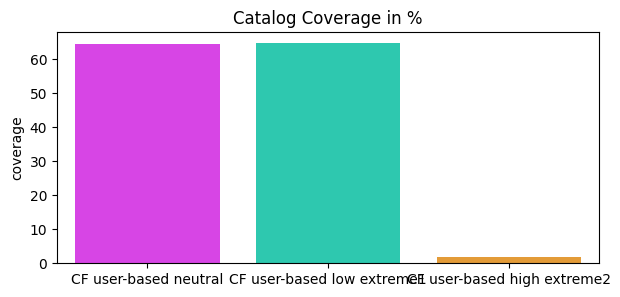

In [ ]:
fig = plt.figure(figsize=(7, 3))
model_names = ['CF user-based neutral', 'CF user-based low extreme1', 'CF user-based high extreme2']
recmetrics.coverage_plot([coverage_user_neutral, coverage_user_extreme1, coverage_user_extreme2], model_names)

In terms of coverage, as expected, the worst performing model is the one having a large k and high shrinkage. With a large neighborhood and heavy shrinkage, recommendations end up being narrower and considered as safe bets. The model zeroes in on items that are rated (and co-rated) by many neighbors (because smaller overlaps get penalized), causing the top 50 anime shows lists to become very similar across different users, and thus covering less distintic items.

The “neutral” and “low extreme” settings use either fewer neighbors, less shrinkage, or both, allowing the algorithm to recommend more “niche” or less universally popular items. As a result, more items appear across different users' top 50 lists, giving coverage values in the mid-60% range.

In [ ]:
personalization_user_neutral = recmetrics.personalization(top_n_neutral_only_items)
print(f'CF user-based with neutral parameters personalization: {personalization_user_neutral}')
personalization_user_extreme1 = recmetrics.personalization(top_n_extreme1_only_items)
print(f'CF user-based with low extreme parameters personalization: {personalization_user_extreme1}')
personalization_user_extreme2 = recmetrics.personalization(top_n_extreme2_only_items)
print(f'CF user-based with high extreme parameters personalization: {personalization_user_extreme2}')

CF user-based with neutral parameters personalization: 0.9006871109344945
CF user-based with low extreme parameters personalization: 0.9006275356470547
CF user-based with high extreme parameters personalization: 0.007423911640772829


In terms of personalization:

With moderate settings, the algorithm produces recommendation lists that are quite distinct from user to user. Even though users may share popular items, enough variety remains to maintain a high personalization score. Each user's nearest neighbors are different, leading to recommendations that are tailored to individual tastes.

Extreme (Low) Parameters settings, which are only slightly extreme compared to the neutral case, still yield high personalization. The recommendation lists remain largely diverse across users, which is reflected in the very similar personalization score to the neutral case.

Both the neutral and low extreme configurations seem to preserve enough of the algorithm's ability to differentiate between users. The slight changes in hyperparameters (for example, a minor reduction in the number of neighbors or slight adjustments in the shrinkage value) don't significantly impact the diversity of recommendations.

In the high extreme configuration case the model tends to recommend the same few items to everyone. This is corroborated by the very low coverage observed (only 1.99% of the catalog), meaning almost all users get almost identical top-50 lists. As a result, the personalization score decreases, indicating almost zero dissimilarity between different users' recommendations.

Therefore, the high extreme parameters force the algorithm to produce a very narrow set of “safe” recommendations, making the recommendations nearly identical for all users (low personalization), while the neutral and low extreme settings allow more diverse, personalized lists.

In [ ]:
diversity_user_neutral = recmetrics.intra_list_similarity(top_n_neutral_only_items, anime_df)
print(f'CF diversity neutral case: {diversity_user_neutral}')
diversity_user_extreme1 = recmetrics.intra_list_similarity(top_n_extreme1_only_items, anime_df)
print(f'CF diversity low extreme case: {diversity_user_extreme1}')
diversity_user_extreme2 = recmetrics.intra_list_similarity(top_n_extreme2_only_items, anime_df)
print(f'CF diversity high extreme case: {diversity_user_extreme2}')

CF diversity neutral case: 0.24154308493901233
CF diversity low extreme case: 0.24161534041749919
CF diversity high extreme case: 0.2898029289752566


In terms of diversity, the three scores are very similar. The items being recommended to users likely have a similar genre distribution in the dataset. Whether you use neutral, low extreme, or even high extreme parameters, the algorithm is still pulling from the same pool of anime, so the overall mix of genres in the top-50 list remains roughly constant.

While changing hyperparameters like neighborhood size or shrinkage can greatly affect coverage and personalization (i.e., differences between users), they have a lesser impact on how varied the recommendations are for a single user.

In both the neutral and low extreme cases, the slight differences in hyperparameters do not significantly alter the ranking of items in terms of genre diversity. Even in the high extreme case, although the recommendations might be more homogenized across users (as seen in personalization and coverage metrics), for an individual user the top-50 list still contains a mix of genres, but leading to a slightly higher diversity that could be due to the high extreme setting favoring widely popular items that come from a broader range of genres.

And finally, from an NDCG perspective.

In [ ]:
trainset, testset = train_test_split(anime_data, test_size=.20, random_state=my_seed)

In [ ]:
user_based_neutral.fit(trainset);
predictions_user_neutral = user_based_neutral.test(testset)
predictions_user_neutral_df = pd.DataFrame(predictions_user_neutral)
predictions_user_neutral_df['est'] = predictions_user_neutral_df['est'].round(2)

user_based_extreme1.fit(trainset);
predictions_user_extreme1 = user_based_extreme1.test(testset)
predictions_user_extreme1_df = pd.DataFrame(predictions_user_extreme1)
predictions_user_extreme1_df['est'] = predictions_user_extreme1_df['est'].round(2)

user_based_extreme2.fit(trainset);
predictions_user_extreme2 = user_based_extreme2.test(testset)
predictions_user_extreme2_df = pd.DataFrame(predictions_user_extreme2)
predictions_user_extreme2_df['est'] = predictions_user_extreme2_df['est'].round(2)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.


In [ ]:
predictions_uneutral_byuser_df = predictions_user_neutral_df.groupby('uid')[['iid', 'r_ui', 'est']].agg(lambda x: list(x))
ndcg_multiple_users(predictions_uneutral_byuser_df['r_ui'].tolist(),
                    predictions_uneutral_byuser_df['est'].tolist())

0.9339243068471427

In [ ]:
predictions_uextreme1_byuser_df = predictions_user_extreme1_df.groupby('uid')[['iid', 'r_ui', 'est']].agg(lambda x: list(x))
ndcg_multiple_users(predictions_uextreme1_byuser_df['r_ui'].tolist(),
                    predictions_uextreme1_byuser_df['est'].tolist())

0.9210661594045331

In [ ]:
predictions_uextreme2_byuser_df = predictions_user_extreme2_df.groupby('uid')[['iid', 'r_ui', 'est']].agg(lambda x: list(x))
ndcg_multiple_users(predictions_uextreme2_byuser_df['r_ui'].tolist(),
                    predictions_uextreme2_byuser_df['est'].tolist())

0.9439830774817002

Lastly, in terms of NDCG:

The neutral model balances between capturing individual user tastes and mitigating noise from sparse co-ratings, helping to rank relevant items near the top for most users, achieving a high final NDCG score. Therefore, moderate hyperparameters allow a good estimation of similarities.

The low extreme model, with only two neighbours, make algorithm's predictions slighltly more unstable. Unregularized similarities (no shrinkage) mean that even a small, unreliable overlap can overly influence predictions, resulting in slightly poorer ranking compared to the neutral case.

Thirdly, a high extreme model achieves the highest NDCG score. Although this setting reduces personalization and coverage (by homogenizing recommendations), the heavy regularization filters out noisy similarities. And by aggregating over many neighbors and heavily penalizing weak co-rating overlaps, the model focuses on the most reliably similar users. However, if we were to choose between this configuration of the other two, we would need to find a trade off between achieve only a slighlty higher NDCG scoer with achieving very low values in coverage and personalization. It also depends on the specific business case or strategy to follow.

### Model-based


The parameters represent the following:
* n_factors: number of latent factors considered.
* n_epochs: number of iteration of the SGD procedure.
* lr_all: learning rate for all parameters.
* reg_all: regularization term for all parameters.
* random_state: RNG that will be used for initialization.

In [ ]:
# Neutral hyperparameters
model_based_neutral = SVD(
    n_factors=100,   # typical default
    n_epochs=20,     # typical default
    lr_all=0.005,    # typical default
    reg_all=0.02,    # typical default
    random_state=42
)

# Extreme case 1 (low-extreme): fewer factors, fewer epochs, higher learning rate
model_based_extreme1 = SVD(
    n_factors=20,
    n_epochs=5,
    lr_all=0.01,    # faster learning
    reg_all=0.0,    # no regularization
    random_state=42
)

# Extreme case 2 (high-extreme): more factors, more epochs, heavier regularization, slower learning
model_based_extreme2 = SVD(
    n_factors=200,
    n_epochs=50,
    lr_all=0.001,   # slower learning
    reg_all=0.1,    # strong regularization
    random_state=42
)

The three cases to be tested are the following:
* Neutral model: with 100 latent factors (moderate capacity to capture underlying user-item interactions), 20 epochs (allow the model to converge reasonably well without taking too long to train), 0.02 regularization to avoid overfitting, and a 0.005 learning rate.
* Low extreme model: with only 20 latent factors (might not capture all the nuances in user-item interactions), 5 epochs (speeding up convergence), no regularization, and a 0.01 learning rate.
* High extreme model: with 200 latent factors (much higher capacity to capture subtle interactions), 50 epochs (model converges slowly and steadily), 0.1 regularization to control overfitting by penalizing large parameter values, and a 0.001 learning rate.

Evaluation from performance/accuracy point of view:

In [ ]:
model_based_neutral.fit(trainset);
predictions_model_neutral = model_based_neutral.test(testset)
accuracy.rmse(predictions_model_neutral, verbose=True);
accuracy.mae(predictions_model_neutral, verbose=True);

RMSE: 1.2006
MAE:  0.9067


In [ ]:
model_based_extreme1.fit(trainset);
predictions_model_extreme1 = model_based_extreme1.test(testset)
accuracy.rmse(predictions_model_extreme1, verbose=True);
accuracy.mae(predictions_model_extreme1, verbose=True);

RMSE: 1.2121
MAE:  0.9197


In [ ]:
model_based_extreme2.fit(trainset);
predictions_model_extreme2 = model_based_extreme2.test(testset)
accuracy.rmse(predictions_model_extreme2, verbose=True);
accuracy.mae(predictions_model_extreme2, verbose=True);

RMSE: 1.2164
MAE:  0.9267


The neutral configuration provides the best accuracy, striking a balance between model capacity and regularization. It reflects that the model has enough capacity/epochs to capture the underlying structure in the data without excessive complexity (100 latent features).

Extreme Case 1 suffers from underfitting due to too few latent factors and insufficient training epochs, resulting in slightly higher RMSE and MAE.

Extreme Case 2 attempts to leverage a higher capacity but uses heavy regularization to prevent overfitting. This oversmoothing leads to a marginal drop in accuracy compared to the neutral setup.
In both extreme cases, the deviations in accuracy are relatively small, suggesting that the neutral configuration is already near the optimal trade-off for this particular dataset. Thus, the impact of the parameters in accuracy metrics is not substantial.

Evaluation of other metrics apart from performance:

In [ ]:
trainset = anime_data_sampled.build_full_trainset()
testset = trainset.build_anti_testset()

model_based_neutral.fit(trainset);
model_based_extreme1.fit(trainset);
model_based_extreme2.fit(trainset);

predictions_model_neutral = model_based_neutral.test(testset)
predictions_model_extreme1 = model_based_extreme1.test(testset)
predictions_model_extreme2 = model_based_extreme2.test(testset)

In [ ]:
top_n_model_neutral= get_top_n(predictions_model_neutral, n=50)
top_n_model_extreme1 = get_top_n(predictions_model_extreme1, n=50)
top_n_model_extreme2 = get_top_n(predictions_model_extreme2, n=50)

top_n_neutral_only_items      = [[iid for (iid, _) in user_ratings] for user_ratings in top_n_model_neutral.values()]
top_n_extreme1_only_items      = [[iid for (iid, _) in user_ratings] for user_ratings in top_n_model_extreme1.values()]
top_n_extreme2_only_items     = [[iid for (iid, _) in user_ratings] for user_ratings in top_n_model_extreme2.values()]

In [ ]:
catalog = [trainset.to_raw_iid(inner_iid) for inner_iid in trainset.all_items()]
coverage_model_neutral = recmetrics.prediction_coverage(top_n_neutral_only_items, catalog)
print(f'CF model-based with neutral parameters coverage: {coverage_model_neutral}')
coverage_model_extreme1 = recmetrics.prediction_coverage(top_n_extreme1_only_items, catalog)
print(f'CF model-based with extreme parameters coverage: {coverage_model_extreme1}')
coverage_model_extreme2 = recmetrics.prediction_coverage(top_n_extreme2_only_items, catalog)
print(f'CF model-based with extreme parameters coverage: {coverage_model_extreme2}')

CF model-based with neutral parameters coverage: 11.3
CF model-based with extreme parameters coverage: 4.25
CF model-based with extreme parameters coverage: 50.89


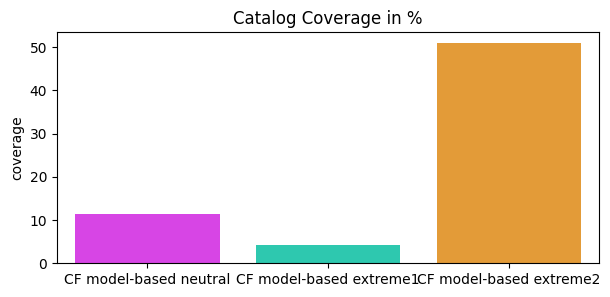

In [ ]:
fig = plt.figure(figsize=(7, 3))
model_names = ['CF model-based neutral', 'CF model-based extreme1', 'CF model-based extreme2']
recmetrics.coverage_plot([coverage_model_neutral, coverage_model_extreme1, coverage_model_extreme2], model_names)

In terms of coverage we observer that:

The neutral SVD allow the model to capture user-item interactions well but still tends to favor a relatively common subset of items, which leads to a moderately low coverage. This suggests that it may require stronger regularization to make the model simpler; or higher number of latent factors.

The CF model-based recommender with extreme low parameters score the lowest in this metric. It indicates underfitting, where the model fails to capture the nuances in user-item interactions due to the few number of epochs it has for the learning process, the rate at which it learns and no regularization. As a result, few items from the whole catalog are covered.

And the CF model-based recommender with extreme high parameters scores the highest. The higher number of epochs and capacity allows the model to capture more subtle differences between items, and heavy regularization prevents overfitting to a small subset of popular items. Therefore, it avoids over-concentration on popular choices, and thereby significantly increasing the coverage.

In [ ]:
personalization_model_neutral = recmetrics.personalization(top_n_neutral_only_items)
print(f'CF user-based with neutral parameters personalization: {personalization_model_neutral}')
personalization_model_extreme1 = recmetrics.personalization(top_n_extreme1_only_items)
print(f'CF user-based with extreme parameters personalization: {personalization_model_extreme1}')
personalization_model_extreme2 = recmetrics.personalization(top_n_extreme2_only_items)
print(f'CF user-based with extreme parameters personalization: {personalization_model_extreme2}')

CF user-based with neutral parameters personalization: 0.30265335761353773
CF user-based with extreme parameters personalization: 0.13156579111777333
CF user-based with extreme parameters personalization: 0.4522825381153682


With moderate settings the algorithm produces recommendation lists that are somewhat distinct across users. the lists share a fair amount of overlap because of the low coverage observed before. So, the catalog from which it drags the recommendations is narrow.

The extreme 1 case (low parameters) has the worst personalization score because  the model fails to capture the full complexity of each user's unique tastes. Also due to the less than 5% coverage of the entire catalog, many users end up with similar latent representations, making the recommendations more homogenized and overlapping.

The extreme high model of SVD parameters achieves the highest score because with more latent factors and a longer training process, the model can finely differentiate between users' preferences. Although heavy regularization might seem like it could smooth out differences, here it helps control overfitting while still allowing each user's unique profile to shine through. However, this score in comparison with that of other types of CF recommender or non-personalized one, performs very badly. probably due to the strong regularization applied that shrinks the latent factors toward zero, making the model less sensitive to differences in the data, and resulting in less tailored and more generic recommendations.

In [ ]:
diversity_model_neutral = recmetrics.intra_list_similarity(top_n_neutral_only_items, anime_df)
print(f'CF neutral case diversity: {diversity_model_neutral}')
diversity_model_extreme1 = recmetrics.intra_list_similarity(top_n_extreme1_only_items, anime_df)
print(f'CF low extreme case diversity: {diversity_model_extreme1}')
diversity_model_extreme2 = recmetrics.intra_list_similarity(top_n_extreme2_only_items, anime_df)
print(f'CF high extreme case diversity: {diversity_model_extreme2}')

CF diversity: 0.24121420034706967
CF diversity: 0.2480311769209732
CF diversity: 0.2411201709813795


Diversity values are very consistent across all three cases, which indicates that, regardless of the SVD hyperparameter tuning in your experiments, the mix of anime genres within each user's top-50 list remains nearly the same. Essentially, even though hyperparameter tuning may affect accuracy or personalization, it has little impact on diversity because the pool of items and their genre distribution remains constant. The changes in predicted scores still tend to produce similar top‑N lists, preserving the overall diversity in recommendations.

We can conclude that diversity metric here may be relatively insensitive to the kinds of changes introduced by these specific hyperparameter adjustments. In other words, while the SVD model’s rating predictions might change slightly, the relative ordering or the set of items that score highest (and their associated genres) remain similar.



Evaluation of NDCGs:

In [ ]:
trainset, testset = train_test_split(anime_data, test_size=.20, random_state=my_seed)

In [ ]:
model_based_neutral.fit(trainset);
predictions_model_neutral = model_based_neutral.test(testset)
predictions_model_neutral_df = pd.DataFrame(predictions_model_neutral)
predictions_model_neutral_df['est'] = predictions_model_neutral_df['est'].round(2)

model_based_extreme1.fit(trainset);
predictions_model_extreme1 = model_based_extreme1.test(testset)
predictions_model_extreme1_df = pd.DataFrame(predictions_model_extreme1)
predictions_model_extreme1_df['est'] = predictions_model_extreme1_df['est'].round(2)

model_based_extreme2.fit(trainset);
predictions_model_extreme2 = model_based_extreme2.test(testset)
predictions_model_extreme2_df = pd.DataFrame(predictions_model_extreme2)
predictions_model_extreme2_df['est'] = predictions_model_extreme2_df['est'].round(2)

In [ ]:
predictions_mneutral_byuser_df = predictions_model_neutral_df.groupby('uid')[['iid', 'r_ui', 'est']].agg(lambda x: list(x))
ndcg_multiple_users(predictions_mneutral_byuser_df['r_ui'].tolist(),
                    predictions_mneutral_byuser_df['est'].tolist())

0.9415725196272811

In [ ]:
predictions_mextreme1_byuser_df = predictions_model_extreme1_df.groupby('uid')[['iid', 'r_ui', 'est']].agg(lambda x: list(x))
ndcg_multiple_users(predictions_mextreme1_byuser_df['r_ui'].tolist(),
                    predictions_mextreme1_byuser_df['est'].tolist())

0.9399102356396482

In [ ]:
predictions_mextreme2_byuser_df = predictions_model_extreme2_df.groupby('uid')[['iid', 'r_ui', 'est']].agg(lambda x: list(x))
ndcg_multiple_users(predictions_mextreme2_byuser_df['r_ui'].tolist(),
                    predictions_mextreme2_byuser_df['est'].tolist())

0.9412338156455958

The diversity conclusions also impact the NDCG scores. All three SVD configurations achieve very similar NDCG values—around 0.94—demonstrating that each model effectively ranks the most relevant items at the top of the recommendation lists, regardless of hyperparameter differences.

A slight drop of about 0.00166 in the second model shows that even with reduced complexity, its ranking performance remains strong. Similarly, despite the third model's higher capacity and stronger regularization, its ranking order remains almost identical to the neutral configuration, yielding an NDCG nearly as high.

In short, while metrics like coverage or personalization may vary more noticeably with hyperparameter changes, the overall ranking quality, as captured by NDCG, remains consistently high across the different SVD configurations.


## 7. Interpretation of latent factors for model-based recommender

In [ ]:
rmse_test_dict = {}
for n in tqdm(range(1, 80, 2)):
  # Let's reduce n_epochs to speed up the execution
  algo = SVD(n_factors=n, n_epochs=20, random_state=my_seed)
  performance = cross_validate(algo, anime_data, measures=['RMSE'],
                               cv=KFold(n_splits=4, random_state=my_seed),
                               verbose=False, n_jobs=-1)
  rmse_test_dict[n] = np.mean(performance['test_rmse'])

100%|██████████| 40/40 [08:52<00:00, 13.30s/it]


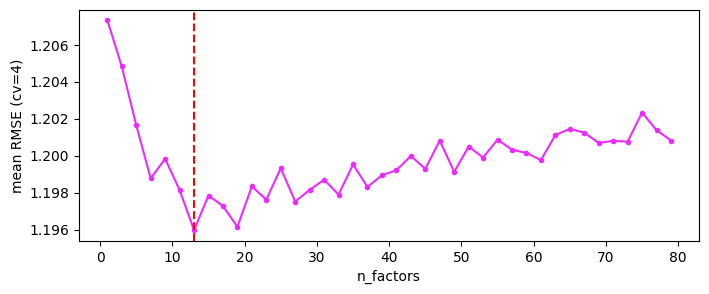

In [ ]:
fig, ax = plt.subplots(figsize=(8,3))
plt.plot(rmse_test_dict.keys(), rmse_test_dict.values(), marker='.');
plt.axvline(x=min(rmse_test_dict, key=rmse_test_dict.get), color='red', linestyle='dashed')
plt.xlabel('n_factors');
plt.ylabel('mean RMSE (cv=4)');

The graph shows how the mean RMSE on the test set (averaged via cross-validation) changes as you vary the number of latent factors.At very low numbers of factors (e.g., 2–10), the model underfits because it cannot capture the complexity of user–item interactions. And, as you increase factors, the model can represent more nuanced patterns, causing the RMSE to drop.

The dashed red line suggests that aorund 13 latent factors is a sweet spot in balancing model capacity and generalization for your dataset. Beyond this point, the RMSE starts to rise again, indicating increasing overfitting.

In [ ]:
# Import again anime's metadata in case it has been corrupted.

dataset_path = 'CooperUnion/anime-recommendations-database'
kaggle.api.dataset_download_files(dataset_path, path=dataset_path, unzip=True)
# ! ls $dataset_path

anime_df = pd.read_csv(f'{dataset_path}/anime.csv')
anime_df.head()

Dataset URL: https://www.kaggle.com/datasets/CooperUnion/anime-recommendations-database


,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [ ]:
anime_df['first_genre'] = anime_df['genre'].apply(lambda x: x.split(', ')[0] if pd.notnull(x) else None)
all_df = ratings_sampled.merge(anime_df, on='anime_id')
#all_df['title_genre'] = all_df['name'] + all_df['genre']

print(f"There are {all_df['user_id'].nunique()} unique users")
print(f"There are {all_df['anime_id'].nunique()} unique anime shows")
print(f"There are {all_df.shape[0]} ratings")

There are 3480 unique users
There are 7243 unique anime shows
There are 323006 ratings


In [ ]:
 # The order is [user_id, anime_id, rating_x]
data_title = Dataset.load_from_df(
    all_df[['user_id', 'anime_id', 'rating_x']],
    reader
)

In [ ]:
algo = SVD(n_factors=2, random_state=my_seed)
algo.fit(data_title.build_full_trainset())


In [ ]:
names = [algo.trainset.to_raw_iid(i) for i in algo.trainset.all_items()]


In [ ]:
df_aux = pd.DataFrame(
    zip(algo.qi.T[0], algo.qi.T[1], names),
    columns=['x', 'y', 'anime_id']
)


In [ ]:
# Convert both sides to the same type if needed
df_aux['anime_id'] = df_aux['anime_id'].astype(str)
anime_df['anime_id'] = anime_df['anime_id'].astype(str)

df_aux = df_aux.merge(anime_df[['anime_id','first_genre']], on='anime_id', how='left')


In [ ]:
# Fill missing or empty first_genre values with a default string
df_aux['first_genre'] = df_aux['first_genre'].fillna("Unknown")
df_aux['first_genre'] = df_aux['first_genre'].replace("", "Unknown")

fig = px.scatter(
    df_aux,
    x='x',
    y='y',
    color='first_genre',
    hover_data=['anime_id', 'first_genre'],
    width=800,
    height=800
)
fig.show()


From the scatterplot (colored by each anime show's primary genre), clear patterns in the latent space are hard to detect, as colors appear evenly distributed. This might be because we're only considering the first genre listed, assuming it's the most representative, even though the genre order might not reflect significance and depends on the logic with which it was created.

However, a few observations can be made:

* Anime about dementia, while generally centered, tend to cluster in the upper right quadrant.
* Ecchi shows tend to occupy the lower quadrants.
* Horror shows are more frequent in the lower left quadrant compared to historical shows.

For the remaining genres, there isn’t enough data to observe any strong patterns. Moreover, when the top three most common genres (action, adventure, and comedy) are incorporated into the scatterplot, their distribution remains similar with no clear pattern emerging. This explains the limited in-depth analysis presented.